In [20]:
import re
import random
import pandas as pd
import hashlib

In [21]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [22]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Compute Gallery,325.852087,8.146302,15.149636,40
C# Basics,605.771965,19.541031,29.547473,31
Open Source/GitHub,623.017517,103.836253,178.209963,6
Azure Private DNS,722.047545,38.002502,58.543631,19
RAG Project,840.612926,52.538308,120.659472,16
Azure AD Authentication,945.028656,72.694512,177.998705,13
Azure Functions + Visual Studio,1027.029352,79.002258,285.991603,13
Email Auth and Security,1062.423879,88.535323,185.700553,12
Audit Report Tracker (Sharepoint List),1063.058932,96.641721,272.210414,11
WSL + Kali Linux,1360.250177,97.160727,387.907490,14


# Histogram

sum of ages: ~48602.94


<Axes: >

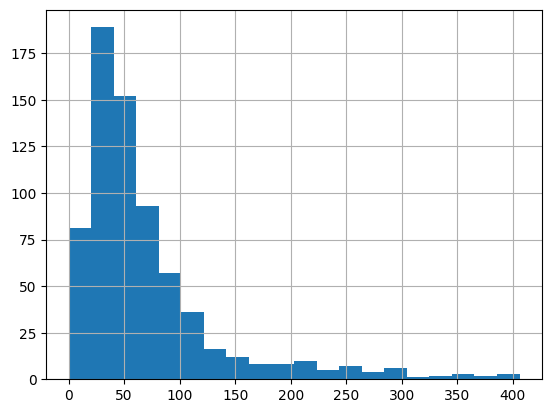

In [23]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [24]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [25]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [26]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [27]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [28]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [29]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [30]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [31]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [32]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [33]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 695
Total card age: 48602.94


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Powershell Modules,CurrentUser Scope\n\nDefinition: An installati...,f3d0d03320782899e1352f748fc1cda5,-405.966533,108.418832,-405.966533,4770.428602,0.919755,0,0
1,Powershell Modules,Pester\n\nDefinition: A testing framework for ...,4e50001e9a04f06dcc20b5666ea220aa,-249.521644,108.418832,-405.966533,4770.428602,0.919755,3,0
2,Powershell Modules,Windows System Modules Directory\nDefinition: ...,dacf48180fbe3c6114565248a4ea6a64,-183.229919,108.418832,-405.966533,4770.428602,0.919755,6,0
3,Powershell Modules,When multiple modules have cmdlets with the sa...,84859510e8fd6779f4e4eed31ac5e85d,-139.487100,108.418832,-405.966533,4770.428602,0.919755,9,0
4,Powershell Modules,Get-Help <CmdletName> -Detailed\n\nDefinition:...,7ee10932f6dc243932e14d837709cd18,-112.576110,108.418832,-405.966533,4770.428602,0.919755,12,0
467,Powershell Modules,Format-List\n\nDefinition: A PowerShell cmdlet...,e53bb49dd43aae2fd3b533e362c1358a,-101.466894,108.418832,-405.966533,4770.428602,0.919755,15,0
6,Powershell Modules,Module Manifest\n\nDefinition: A PowerShell da...,73e06e6668fe664f8ef7bbdca3a655d2,-96.986462,108.418832,-405.966533,4770.428602,0.919755,18,0
7,Powershell Modules,Module Path\n\nDefinition: The directories whe...,0ed10fbc284c0a9a7c52e763081c5d43,-74.425872,108.418832,-405.966533,4770.428602,0.919755,21,0
8,Powershell Modules,ActiveDirectory Module\n\nDefinition: A module...,089fb36f01ae2d8da1791e9a07f2af99,-70.641176,108.418832,-405.966533,4770.428602,0.919755,24,0
470,Powershell Modules,Module Conflicts\n\nDefinition: Situations whe...,b1c3faa6a5749b8ab2e1f48ea517b0e8,-66.313088,108.418832,-405.966533,4770.428602,0.919755,27,0


## Card Count

In [34]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [35]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [36]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Powershell Modules,CurrentUser Scope\n\nDefinition: An installati...,f3d0d03320782899e1352f748fc1cda5,-405.966533,108.418832,-405.966533,4770.428602,0.919755,0,0
15,WSL + Kali Linux,WSLg (Windows Subsystem for Linux GUI)\nA feat...,69051af876862485bdb54d8c645a8a40,-387.907490,97.160727,-387.907490,1360.250177,0.160830,0,0
20,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-386.576603,73.749230,-386.576603,4646.201462,0.598310,0,0
236,Powershell Modules,Auto-Import\n\nDefinition: A feature in PowerS...,6b1412630951dc5fee8ffa437ee0e0f2,-382.775405,108.418832,-405.966533,4770.428602,0.919755,1,1
41,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,-369.839346,92.323644,-369.839346,4800.829475,0.084986,0,0
462,Powershell Modules,Get-Module\n\nDefinition: A cmdlet that retrie...,0d76065f3213ee411ee6f7e377583cc9,-356.738487,108.418832,-405.966533,4770.428602,0.919755,2,2
59,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,-351.628452,76.482645,-351.628452,1835.583484,0.207859,0,0
75,Azure Developer Associate,Which Azure Monitor table holds platform metri...,52fbf976aa2ccee89121f7b5694acfce,-350.688180,69.280200,-350.688180,3810.411023,0.908914,0,0
67,FSLogix,"During a first-time sign-in, FSLogix creates t...",f2d84db5972e92abd44bdb7e0c5686a7,-340.948730,71.090091,-340.948730,2417.063083,0.384456,0,0
302,FSLogix,Q: Which format does FSLogix use to store user...,2502a81cff9047e83fa1e04a99225de5,-337.020504,71.090091,-340.948730,2417.063083,0.384456,1,1


In [37]:
existing_cards.head(10).sum()

head                   Powershell ModulesPowershell ModulesPowershell...
body                   CurrentUser Scope\n\nDefinition: An installati...
hash                   f3d0d03320782899e1352f748fc1cda54e50001e9a04f0...
age                                                         -1500.614798
subject_mean_age                                             1084.188319
subject_highest_age                                         -4059.665329
subject_age_sum                                             47704.286021
head_random_roll                                                9.197553
count                                                                135
n_fold                                                                 0
dtype: object

In [38]:
existing_cards['age'].mean()

-69.93229320832404